<a href="https://colab.research.google.com/github/Sushmithaa-Pandian/Machine_learning_sush/blob/main/Zenithhack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install keras_nlp --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import pathlib
import random
import string
import re
import sys
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import rankdata
import json
import keras_nlp

In [ ]:
df=pd.read_csv("/content/drive/My Drive/zenith-dataset/train.csv")
df['ToDo']=df['TITLE']+df['ABSTRACT']
df=df[['ID','ToDo','Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']]
df.head()

,ID,ToDo,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps P...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network Rotation i...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0


In [ ]:
class Config:
    batch_size = 128
    validation_split = 0.15
    epochs = 10 # Number of Epochs to train
    model_path = "model.h5"
    output_dataset_path = "/content/drive/My Drive/zeni"
    labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
    modes = ["training", "inference"]
    mode = modes[1]
    model_name = "distil_bert_base_en_uncased"
config = Config()

In [ ]:
train=df
train.head()

,ID,ToDo,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps P...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network Rotation i...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train["ToDo"], train[config.labels], test_size=config.validation_split)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((17826,), (17826, 6), (3146,), (3146, 6))

In [ ]:
def make_dataset(X, y, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if mode == "train":
       dataset = dataset.shuffle(batch_size * 4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE).repeat(1)
    return dataset

In [ ]:
train_ds = make_dataset(X_train, y_train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(X_val, y_val, batch_size=config.batch_size, mode="valid")

In [ ]:
for batch in train_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'Jamming Resistant Receivers for Massive MIMO  We design jamming resistant receivers to enhance the robustness of a massive\nMIMO uplink channel against jamming. In the pilot phase, we estimate not only\nthe desired channel, but also the jamming channel by exploiting purposely\nunused pilot sequences. The jamming channel estimate is used to construct the\nlinear receive filter to reduce impact that jamming has on the achievable\nrates. The performance of the proposed scheme is analytically and numerically\nevaluated. These results show that the proposed scheme greatly improves the\nrates, as compared to conventional receivers. Moreover, the proposed schemes\nstill work well with stronger jamming power.\n',
       b'An estimate of the root mean square error incurred when approximating an $f \\in L^2({\\mathbb{R}})$ by a partial sum of its Hermite series  Let $f$ be a band-limited function in $L^2({\\mathbb{R}})$. Fix $T >0$ and\nsu

In [ ]:
def get_model(config):
    encoder = keras_nlp.models.DistilBertBackbone.from_preset(
        config.model_name
    )
    encoder.trainable = False
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
        config.model_name
    )
    inputs = keras.Input(shape=(), dtype=tf.string)
    x = preprocessor(inputs)
    x = encoder(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    output = layers.Dense(6, activation="sigmoid")(x)
    model = keras.Model(inputs, output, name="model")
    model.compile(
        "adam", loss="SparseCategoricalCrossentropy", metrics=["categorical_accuracy", keras.metrics.AUC()]
    )
    return model

In [ ]:
model = get_model(config)
model.summary()

231508/231508 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 distil_bert_preprocessor (Dist  {'token_ids': (None  0          ['input_1[0][0]']                
 ilBertPreprocessor)            , 512),                                                           
                                 'padding_mask': (N                                               
                                one, 512)}                                                        
                                                                                                  
 distil_bert_backbone (DistilBe  

In [ ]:
if config.mode == config.modes[0]:
    checkpoint = keras.callbacks.ModelCheckpoint(config.model_path, monitor="val_categorical_accuracy", save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-6)
    model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, reduce_lr])

In [ ]:
cls_report={}

In [ ]:
if config.mode == config.modes[0]:
    from sklearn.metrics import classification_report
    y_pred = np.array(model.predict(valid_ds) > 0.5, dtype=int)
    cls_report = classification_report(y_val, y_pred)
    print(cls_report)

25/25 [==============================] - 73s 3s/step


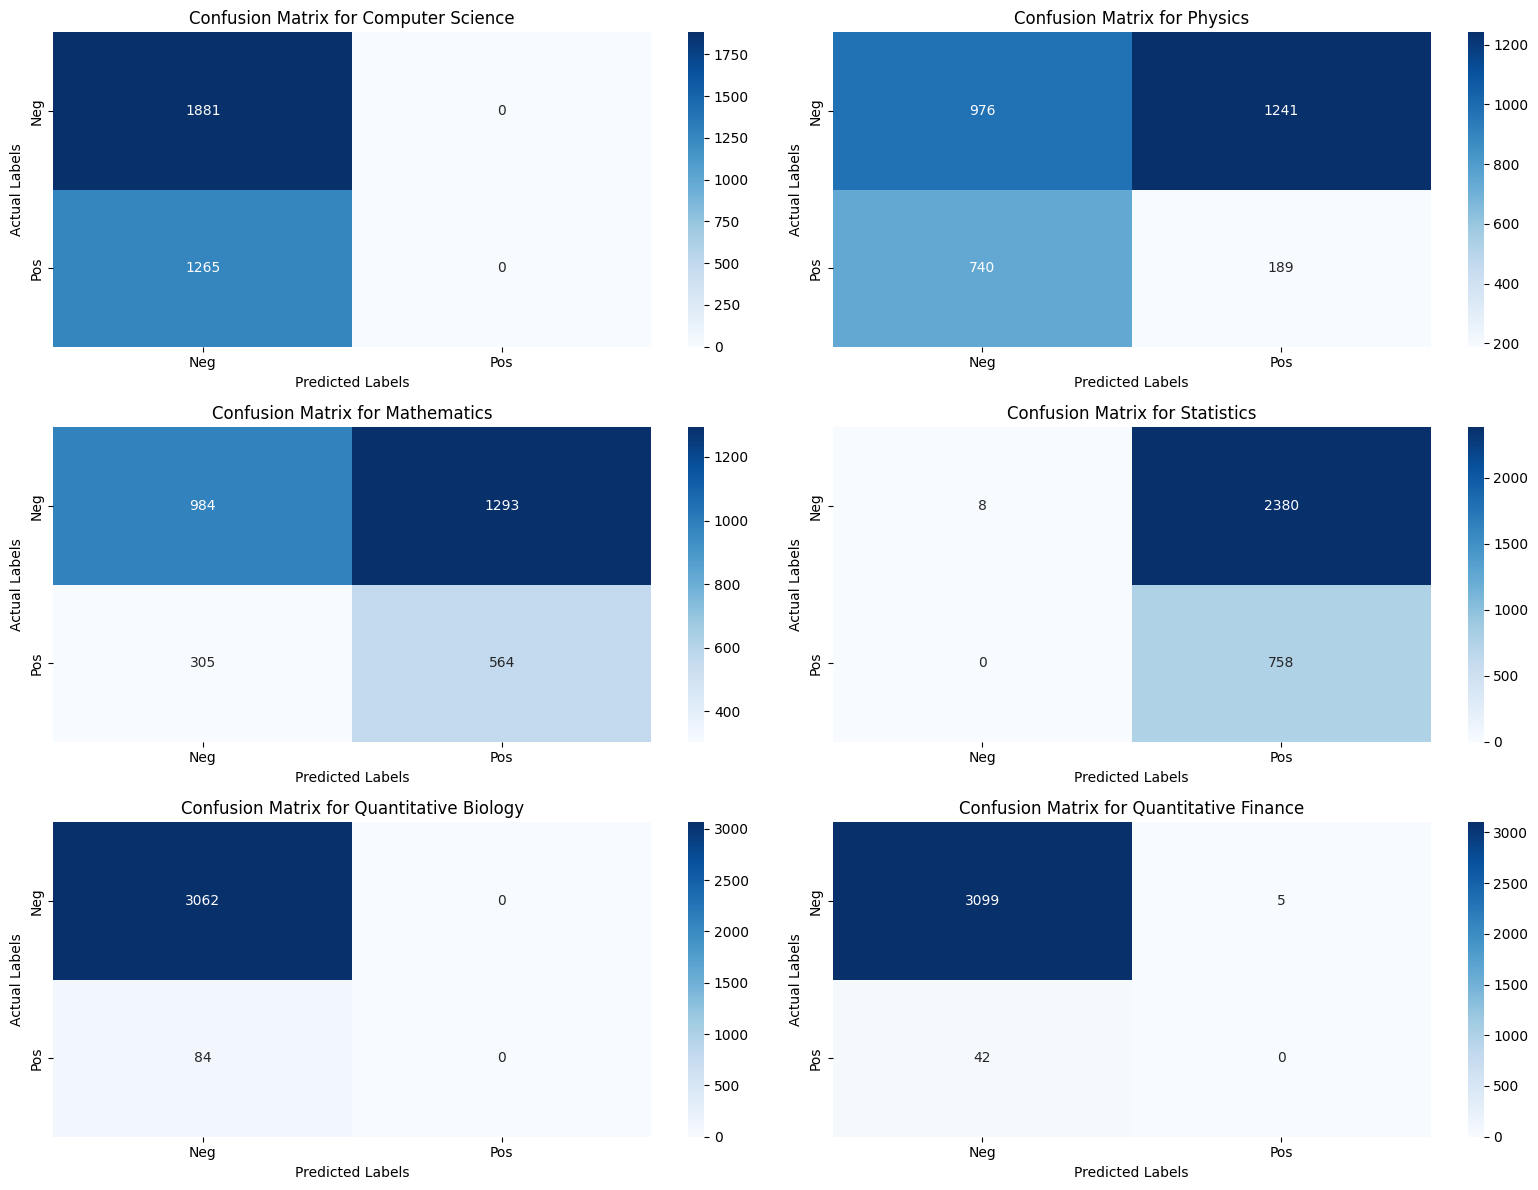

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

y_pred = np.array(model.predict(valid_ds) > 0.5, dtype=int)

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
z

array([[[1881,    0],
        [1265,    0]],

       [[ 976, 1241],
        [ 740,  189]],

       [[ 984, 1293],
        [ 305,  564]],

       [[   8, 2380],
        [   0,  758]],

       [[3062,    0],
        [  84,    0]],

       [[3099,    5],
        [  42,    0]]])

In [ ]:
model.save('/content/drive/My Drive/zeni')

In [ ]:
test=pd.read_csv("/content/drive/My Drive/zenith-dataset/test.csv")
test['ToDo']=test['TITLE']+test['ABSTRACT']
test=test[['ID','ToDo']]
test.head()

,ID,ToDo
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...
1,20974,Laboratory mid-IR spectra of equilibrated and ...
2,20975,Case For Static AMSDU Aggregation in WLANs Fr...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...
4,20977,Witness-Functions versus Interpretation-Functi...


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/zeni')

In [ ]:
tf.keras.models.save_model(loaded_model,'/content/drive/My Drive/zeni/model.h5')

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((test["ToDo"])).batch(config.batch_size).cache().prefetch(1)
path = config.model_path
if config.mode == config.modes[1]:
    path = config.output_dataset_path + "/" + path
model.load_weights(path)
score = model.predict(test_ds)

71/71 [==============================] - 222s 3s/step
